1. Eliminate small blobs, does not eliminate blobs with high compactness value
2. Collect typical blob by local blob matching
3. Collect false typical blob by matching blobs with blobs far away in the same section 
    - Set a cut off radius and compare this blob with all the blobs outside this radius on the same section
    - Collect the best matched pair. Or alternatively, randomly sample the outside blob and form a pair
4. Run over the entire brain
    - No need in the first trail,where we just need to get a large enough region. Let's look at the whole image first. 
5. Train the average perceptron with the same features
6. Train the average perceptron with more features


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import sys, os, time, collections

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR']bb, 'learning'))

import numpy as np
import scipy
import skimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *
from utilities2015 import *
from cell_utilities import *
from metadata import *
from distributed_utilities import download_from_s3

save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/'
from xj_utilities import *
fun_create_folder(save_folder_path=save_folder_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Folder already exists: /shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/

In [3]:
scan_parameters = {}

In [5]:
scan_parameters['stack'] = 'MD589'
scan_parameters['patch_size'] = 448
scan_parameters['patch_half_size'] = scan_parameters['patch_size']/2
scan_parameters['stride'] = 112

scan_parameters['section_limits'] = metadata_cache['section_limits'][scan_parameters['stack']]
scan_parameters['o_crop'] = True
scan_parameters['o_clear_border'] = True
scan_parameters['o_relabel'] = True
scan_parameters['oriImL1'], scan_parameters['oriImL0'] = metadata_cache['image_shape'][scan_parameters['stack']]
scan_parameters['scan_section_range'] = 1

scan_parameters['prop'] = ['centroid','eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter','perimeter','compactness','label','major_axis_length','minor_axis_length']
scan_parameters['prop_for_comparison'] = ['area', 'eccentricity']
if 'moments_hu' in scan_parameters['prop_for_comparison']:
    scan_parameters['compare_weight'] = [1 for i in range(6 + len(scan_parameters['prop_for_comparison']))]
else:
    scan_parameters['compare_weight'] = [1 for i in range(len(scan_parameters['prop_for_comparison']))]
scan_parameters['compare_weight'] = np.array(scan_parameters['compare_weight'])/ float(np.sum(scan_parameters['compare_weight']))
scan_parameters['similarity_threshold'] = 0.9
scan_parameters['o_fix_scan_size'] = True
scan_parameters['scan_size'] = 112
scan_parameters['scan_size_coeff'] = 5
scan_parameters['builtInProps'] = ['centroid','orientation', 'eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter','label','local_centroid','major_axis_length','solidity','minor_axis_length','perimeter','solidity']
scan_parameters['prop_to_save'] = ['coords','moments_hu','centroid','area','eccentricity','equivalent_diameter']
scan_parameters['scan_outside_margin'] = 1000
stack = scan_parameters['stack']

In [6]:
contour_df = DataManager.load_annotation_v4(stack=scan_parameters['stack'],by_human=True,suffix='contours',timestamp='latest')
contour_df = convert_annotation_v3_original_to_aligned_cropped(contour_df=contour_df,stack=stack)
structure_name = '7N'
vertice_7N_dic = {record['section']:np.array(record['vertices'],np.int) for _, record in contour_df[contour_df['name']==structure_name].iterrows()}
sectionList_7N = np.sort(vertice_7N_dic.keys())

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/shared/CSHL_labelings_v3/MD589" --exclude "*" --include "*contours*"
latest timestamp:  07292017045157


In [7]:
margin = 10
bboxs_7N = {sec:fun_polygon_bbox(vertice_7N_dic[sec]) for sec in sectionList_7N}
bbox_7N = fun_polygons_bbox(bboxs_7N.values(),margin=margin)
# bbox_7N = bboxs_7N[154]
scan_parameters['crop_range_mmxx'] = bbox_7N
scan_parameters['crop_0_min'], scan_parameters['crop_1_min'],scan_parameters['crop_0_max'],scan_parameters['crop_1_max'] = bbox_7N 
scan_parameters['im0max'] = scan_parameters['crop_0_max'] - scan_parameters['crop_0_min']
scan_parameters['im1max'] = scan_parameters['crop_1_max'] - scan_parameters['crop_1_min']
scan_parameters['crop_range_mxmx'] = fun_mmxx_to_mxmx(*scan_parameters['crop_range_mmxx'])

In [8]:
# loading data
image = {}
stack = scan_parameters['stack']
section_begin, section_end = scan_parameters['section_limits']
# secList = range(section_begin, section_end+1)
# tempSecList = range(section_begin, section_end+1)
load_section_idx_range = range(0,min(30, len(sectionList_7N)))
secList = list(sectionList_7N[load_section_idx_range])
tempSecList = list(sectionList_7N[load_section_idx_range])
for tempSec in tempSecList:
    try:
        image[tempSec] = fun_crop_images(DataManager.load_image_v2(stack=stack, section=tempSec, version='jpeg', prep_id=2),*scan_parameters['crop_range_mmxx'],im0max=scan_parameters['oriImL0'],im1max=scan_parameters['oriImL1'] )
    except:
        sys.stderr.write('Invalid section %d...\n'%tempSec)
        secList.remove(tempSec)
        continue
#     if os.path.isfile(img_filename[tempSec]):
#         sys.stderr.write('Image file is already available. \n')
#         continue
#     else:
#         try:
#             download_from_s3(img_filename[tempSec])
#         except:
#             sys.stderr.write('Download fail. Skip this file for section %d...\n'%tempSec)
#             secList.remove(tempSec)
#             continue   
scan_parameters['secList'] = secList

/usr/local/lib/python2.7/dist-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (185246720 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


rm -rf "/shared/CSHL_data_processed/MD589/MD589_prep2_lossless_jpeg/MD589-N30-2015.07.30-18.03.11_MD589_1_0088_prep2_lossless_jpeg.jpg" && mkdir -p "/shared/CSHL_data_processed/MD589/MD589_prep2_lossless_jpeg"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_prep2_lossless_jpeg/MD589-N30-2015.07.30-18.03.11_MD589_1_0088_prep2_lossless_jpeg.jpg" "/shared/CSHL_data_processed/MD589/MD589_prep2_lossless_jpeg/MD589-N30-2015.07.30-18.03.11_MD589_1_0088_prep2_lossless_jpeg.jpg"
rm -rf "/shared/CSHL_data_processed/MD589/MD589_prep2_lossless_jpeg/MD589-IHC30-2015.07.30-23.20.46_MD589_1_0088_prep2_lossless_jpeg.jpg" && mkdir -p "/shared/CSHL_data_processed/MD589/MD589_prep2_lossless_jpeg"
aws s3 cp "s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_prep2_lossless_jpeg/MD589-IHC30-2015.07.30-23.20.46_MD589_1_0088_prep2_lossless_jpeg.jpg" "/shared/CSHL_data_processed/MD589/MD589_prep2_lossless_jpeg/MD589-IHC30-2015.07.30-23.20.46_MD589_1_0088_prep2_lossless_jpeg.jpg"
rm

In [9]:
scan_range = scan_parameters['scan_section_range']
im0max = scan_parameters['im0max']
im1max = scan_parameters['im1max']
prop = scan_parameters['prop']
prop_for_comparison = scan_parameters['prop_for_comparison']
compare_weight = scan_parameters['compare_weight']
o_simil_threshold = scan_parameters['similarity_threshold']
o_fix_scan_size = scan_parameters['o_fix_scan_size']
o_scan_size_coeff = scan_parameters['scan_size_coeff']
o_scan_size = scan_parameters['scan_size']  
secList = scan_parameters['secList'] 
stack = scan_parameters['stack']

data_typical_blobs = {}
data_matched_paris = {}
data_false_typical_blobs = {}
data_false_matched_pairs = {}
data_blob_prop_dic = {}
data_blob_idx_selection = {}
section = 154
# for section in secList:
typical_blobs = []
matched_paris = []
false_typical_blobs = []
false_matched_paris = []
cell_centroids = {}
cell_numbers = {}
cell_global_coord = {}
im_blob_prop = {}
im_label_ori = {}
im_label = {}
im_BW = {}
sec_load_data_list = range(section - scan_range, section + scan_range + 1)
scan_section = list(sec_load_data_list)
scan_section.remove(section)
### loading data and reconstructed labeled images ###
tempList = list(sec_load_data_list)
for tempSec in tempList:
#         print('process section %d'%tempSec)
    if tempSec in secList:
        cell_global_coord[tempSec] = load_cell_data('coords', stack=stack, sec=tempSec)
#             print('load section %d'%tempSec)
        temp_im_label, temp_im_blob_prop, _ = fun_reconstruct_labeled_image(cell_global_coord[tempSec],crop_range= scan_parameters['crop_range_mxmx'], 
                                                                    oriImL0=scan_parameters['oriImL0'],oriImL1=scan_parameters['oriImL1'])
        im_label[tempSec] = temp_im_label
        im_BW[tempSec] = temp_im_label > 0
        im_blob_prop[tempSec] = np.array(temp_im_blob_prop)
    else:
        sys.stderr.write('Warning: missing section %d'%tempSec)
#             print(scan_section)
        scan_section.remove(tempSec)
#             print(scan_section)
#             print(sec_load_data_list)
        sec_load_data_list.remove(tempSec)
#             print(sec_load_data_list)

### Start getting region properties of each blob    ###
blob_prop_dic = fun_regionprops_dic(im_blob_prop=im_blob_prop,scan_parameters=scan_parameters)
data_blob_prop_dic[section] = blob_prop_dic[section] # Save data
blob_idx_selection = {tempSec : np.logical_and.reduce(np.row_stack(
    (blob_prop_dic[tempSec]['compactness']>0,
#      blob_prop_dic[tempSec]['compactness']<2.5,
     blob_prop_dic[tempSec]['area']<3000,
     blob_prop_dic[tempSec]['area']>200))) for tempSec in sec_load_data_list}  

data_blob_idx_selection[section] = blob_idx_selection[section] # Save data

n_blobs = {tempSec: len(im_blob_prop[tempSec]) for tempSec in im_blob_prop.keys()}
secList_in_BlobPropDic = im_blob_prop.keys()
if set(scan_section).issubset(set(secList_in_BlobPropDic)):
    pass
else:
    print('Warrning: Scaned section(s) not included in input im_blob_prop')



### Start scanning ###
for blobID in range(n_blobs[section]):
    if (blobID % 1000 == 0):
        print('Section %d Finished percentage: %f'%(section, (float(blobID)*100 / n_blobs[section]) ))

    temp_curr_blob_props = {}
    for tempProp in prop:
        temp_curr_blob_props[tempProp] = blob_prop_dic[section][tempProp][blobID]
#         if tempProp in scan_parameters['builtInProps']:
#             temp_curr_blob_props[tempProp] = im_blob_prop[section][blobID][tempProp]
#         elif tempProp == 'compactness':
#             temp_curr_blob_props[tempProp] = im_blob_prop[section][blobID]['perimeter']**2/(4*PI*im_blob_prop[section][blobID]['area'])

    if not blob_idx_selection[section][blobID]:
#         print('Blob %d eliminated'%blobID)
        continue



    tempB1_idx_loc = temp_curr_blob_props['centroid']
    if o_fix_scan_size:
        temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max,o_form='2D')
        temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max)
    else:
        temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max,o_form='2D')
        temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max)


    for tempSec in scan_section:
#         print('Blbo %d left. Start scanning'%blobID)
        if tempSec not in secList_in_BlobPropDic:
            continue

        # Find blobs at the nearby location in the scaned section
        # Method 1
        tempBlobInside = fun_blobs_in_polygen(blob_prop_dic[tempSec]['centroid'],temp_next_sec_range,coor_order='cr')
        tempBlobOutside = fun_blobs_out_polygen(blob_prop_dic[tempSec]['centroid'], temp_next_sec_range, coor_order='cr', margin=scan_parameters['scan_outside_margin'])
#         tempPath = matplotlib.path.Path(temp_next_sec_range)
#         tempBlobInside = tempPath.contains_points(blob_prop_dic[tempSec]['centroid'])
        tempBlobInsideIndex = np.where(tempBlobInside)[0]
        temp_num_blob = len(tempBlobInsideIndex)
        tempBlobOutsideIndex = np.where(tempBlobOutside)[0]
        temp_num_outblob = len(tempBlobOutsideIndex)

        if temp_num_blob:
            temp_sim = {}
            for temp_prop in prop_for_comparison:
                      temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop], blob_prop_dic[tempSec][temp_prop][tempBlobInside],distance_type=temp_prop))
            temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in prop_for_comparison))

            #### Blob comparison ####
            temp_weighted_sim = np.dot(temp_sim_matrix,compare_weight)
            temp_compare_result = temp_weighted_sim > o_simil_threshold
            if any(temp_compare_result.tolist()):
#                 print('Typical blob found: Blob %d similarity %f'%(blobID,max(temp_weighted_sim)))
                typical_blobs.append([section,blobID, im_blob_prop[section][blobID]])
                matched_paris.append([section,blobID,im_blob_prop[section][blobID],tempSec, tempBlobInsideIndex[temp_compare_result], im_blob_prop[tempSec][tempBlobInsideIndex[temp_compare_result]],temp_sim_matrix[temp_compare_result,:]])
#             temp_next_sec_blob_prop = np.array(im_blob_prop[tempSec])[tempBlobInsideIndex]
        else:
#             print('No blobs found in this section')
            pass


        if temp_num_outblob:
            temp_false_sim = {}
            for temp_prop in prop_for_comparison:
                      temp_false_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop], blob_prop_dic[tempSec][temp_prop][tempBlobOutside],distance_type=temp_prop))
            temp_false_sim_matrix = np.column_stack((temp_false_sim[temp_prop] for temp_prop in prop_for_comparison))

            #### Blob comparison ####
            temp_weighted_false_sim = np.dot(temp_false_sim_matrix,compare_weight)
            temp_false_compare_result = temp_weighted_false_sim > o_simil_threshold
            if any(temp_false_compare_result.tolist()):
#                 print('Typical blob found: Blob %d similarity %f'%(blobID,max(temp_weighted_sim)))
                false_typical_blobs.append([section,blobID, im_blob_prop[section][blobID]])
                false_matched_paris.append([section,blobID,im_blob_prop[section][blobID],
                                            tempSec, 
                                            tempBlobOutsideIndex[temp_false_compare_result], 
                                            im_blob_prop[tempSec][tempBlobOutsideIndex[temp_false_compare_result]],
                                            temp_false_sim_matrix[temp_false_compare_result,:]])
#             temp_next_sec_blob_prop = np.array(im_blob_prop[tempSec])[tempBlobInsideIndex]
        else:
#             print('No blobs found in this section')
            pass
data_typical_blobs[section] = typical_blobs
data_matched_paris[section] = matched_paris
data_false_typical_blobs[section] = false_typical_blobs
data_false_matched_pairs[section] = false_matched_paris   

Section 154 Finished percentage: 0.000000
Section 154 Finished percentage: 89.206066


In [11]:
metadata_cache['sections_to_filenames'][stack][152]

'MD589-N26-2015.07.30-17.44.37_MD589_3_0078'

In [21]:
'%(fn)s_%(name)s_aaa'%{'fn':'bbb', 'name':'hahaha'}

'bbb_hahaha_aaa'

In [23]:
a = 'aaa'
b = a + 'b'
b

'aaab'

# Analyze typical blobs  - Histograms

In [8]:
data_typical_blobs_properties = {}
for tempSec in data_typical_blobs.keys():
    data_typical_blobs_properties[tempSec] = [record[2] for record in data_typical_blobs[tempSec]]

data_typical_blobs_properties = fun_regionprops_dic(data_typical_blobs_properties, scan_parameters)
data_typical_blobs_properties_flatten = {}
# typical_blob_properties, might be dubplicated due to multiple sections matching
for tempProp in scan_parameters['prop']:
    data_typical_blobs_properties_flatten[tempProp] = np.concatenate(tuple([data_typical_blobs_properties[tempSec][tempProp] for tempSec in data_typical_blobs_properties.keys()]))
# dd for delete-duplicated
data_typical_blobs_properties_dd = {}
for tempProp in scan_parameters['prop']:
    data_typical_blobs_properties_dd[tempProp] =  np.concatenate(tuple([data_blob_prop_dic[tempSec][tempProp][np.unique(data_typical_blobs_properties[tempSec]['label'])-1] for tempSec in data_blob_prop_dic.keys()]))
# All detected blob properties in the cropped region
data_blob_prop_dic_flatten = {}
data_selected_blob_props_flatten_dic = {}
for tempProp in scan_parameters['prop']:
    data_blob_prop_dic_flatten[tempProp] = np.concatenate(tuple([data_blob_prop_dic[tempSec][tempProp] for tempSec in data_blob_prop_dic.keys()]))
# All the selected blob properties in the cropped region
temp_selected_idx_flatten = np.logical_and(data_blob_prop_dic_flatten['area']>200, data_blob_prop_dic_flatten['area']<3000)
for tempProp in scan_parameters['prop']:
    data_selected_blob_props_flatten_dic[tempProp] = data_blob_prop_dic_flatten[tempProp][temp_selected_idx_flatten]

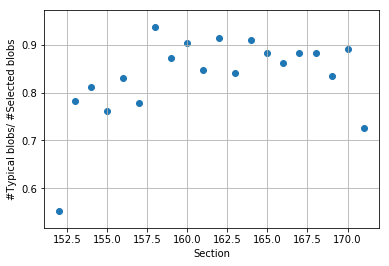

In [112]:
temp_num_typical_blob = [np.count_nonzero(np.unique(data_typical_blobs_properties[tempSec]['label'])) for tempSec in secList]
temp_num_selected_blob = [np.count_nonzero(data_blob_idx_selection[tempSec]) for tempSec in secList]
plt.scatter(np.array(secList), np.array(temp_num_typical_blob, dtype=np.float) / np.array(temp_num_selected_blob, dtype=np.float))
plt.xlabel('Section')
plt.ylabel('#Typical blobs/ #Selected blobs')
plt.grid()

This figure shows the ratio between the number of typical blobs found and the number of selected blobs. The ratio is low for the first and the last point (correspond to section 152 and section 171) and that's because they can only find similar blob in one section ( section 151 and section 172 are not included in the loaded data). 

It seems that the similarity threshold for the typical blob collection is too low. Do we really want aobut 85% of the blob to be similar? 

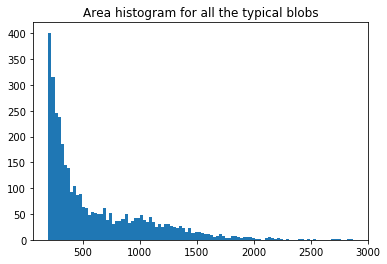

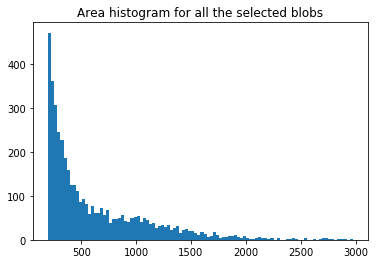

In [78]:
plt.hist(data_typical_blobs_properties_dd['area'],bins=100);
plt.title('Area histogram for all the typical blobs')
plt.figure()
plt.hist(data_selected_blob_props_flatten_dic['area'],bins=100);
plt.title('Area histogram for all the selected blobs')

Cannot tell much difference...

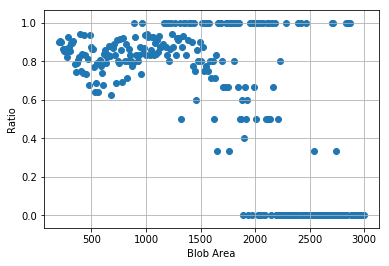

In [81]:
temp_num_bin = 281
temp1 = np.histogram(data_typical_blobs_properties_dd['area'], bins=temp_num_bin,range=(200,3000))
temp2 = np.histogram(data_selected_blob_props_flatten_dic['area'], bins=temp_num_bin,range=(200,3000))
plt.scatter(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp1[0]+0.000000000001)/(temp2[0] + 0.00000001))
plt.xlabel('Blob Area')
plt.ylabel('Ratio')
plt.grid()

Ratio of binned area between typicl blobs and selected blobs 
1. Verify the correctness of the algorithm ( ratio not larger than 1 )
2. Many blobs larger than 2000 pixels are eliminated.

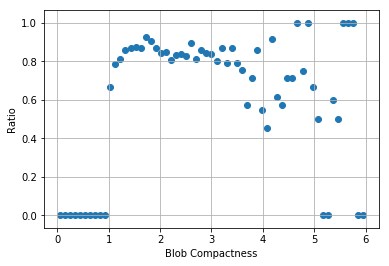

In [86]:
temp_num_bin = 61
temp_range = (0,6)
temp1 = np.histogram(data_typical_blobs_properties_dd['compactness'], bins=temp_num_bin,range=temp_range)
temp2 = np.histogram(data_selected_blob_props_flatten_dic['compactness'], bins=temp_num_bin,range=temp_range)
plt.scatter(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp1[0]+0.00000000001)/(temp2[0] + 0.00000001))
plt.xlabel('Blob Compactness')
plt.ylabel('Ratio')
plt.grid()

Ratio of binned compactness counts between typical blobs and selected blobs
1. It seems that blobs of different compactness are eliminated unbiasely in the matching process. For compactness in (1,3), the ratio seems flat. Any way to quantify the unbiased elimination? 

2. Need to plot the standard deviation:
    - bin ratio according to compactness
    - compute the standard deviation for each bin 
    - plot scatter point with error bar
    - alternative: box plot: plt.boxplot([data_typical_blobs_properties_dd['area'], ])


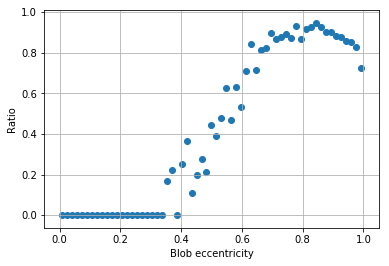

In [89]:
temp_num_bin = 61
temp_range = (0,1)
tempProp = 'eccentricity'
temp1 = np.histogram(data_typical_blobs_properties_dd[tempProp], bins=temp_num_bin,range=temp_range)
temp2 = np.histogram(data_selected_blob_props_flatten_dic[tempProp], bins=temp_num_bin,range=temp_range)
plt.scatter(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp1[0]+0.00000000001)/(temp2[0] + 0.00000001))
plt.xlabel('Blob ' + tempProp)
plt.ylabel('Ratio')
plt.grid()

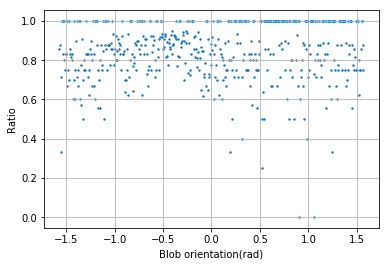

In [118]:
PI = 3.1415926
temp_num_bin = 500
temp_range = (-PI/2 ,PI/2)
tempProp = 'orientation'
temp1 = np.histogram(data_typical_blobs_properties_dd[tempProp], bins=temp_num_bin,range=temp_range)
temp2 = np.histogram(data_selected_blob_props_flatten_dic[tempProp], bins=temp_num_bin,range=temp_range)
plt.scatter(scipy.signal.convolve(temp1[1],np.ones([2,])*0.5,mode='valid'),(temp1[0]+0.00000000001)/(temp2[0] + 0.00000001),s=2)
plt.xlabel('Blob ' + tempProp+'(rad)')
plt.ylabel('Ratio')
plt.grid()

# Analyze mis-matched blobs